<a href="https://colab.research.google.com/github/alina-bogdanovskaya/Data-Analysis_May2022/blob/lesson6/Data_Analysis_lesson6_adaboost_log_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.datasets import load_breast_cancer
from sklearn import model_selection
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [32]:
X, y = load_breast_cancer(return_X_y=True)

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=34)

In [34]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [35]:
def log_loss(pred, y):
  return -np.sum(y * np.log2(pred) + (1 - y) * np.log2(1 - pred))/len(y)

In [36]:
def adaboost_decision_tree(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [37]:
def adaboost_log_regression(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))
    
    # Зададим порог вероятности
    thr = 0.5

    # Начальные веса моделей
    w = np.ones(n_objects) / n_objects

    # Модели с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим модель и обучим ее
        clf = LogisticRegression(max_iter=10000)
        clf.fit(X, y, sample_weight=w)
        
        probability = clf.predict_proba(X)[:, 1]
        err = log_loss(probability, y)
        # отбросим модель, если ее ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if err >= 1 - 1/n_classes: 
            break

        # Вычислим вес для модели
        alpha = 0.5 * np.log((1 - err) / err)

        # Найдем индексы правильно классифицированных элементов
        match = (probability > 0.5) == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим модель с весом в список
        models.append((alpha, clf))
    
    return models

In [38]:
N = 50

trees = adaboost_decision_tree(X_train, y_train, N)
models = adaboost_log_regression(X_train, y_train, N)

In [39]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        y_pred[range(n_objects), prediction] += alpha
    
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [40]:
def predict_log_regression(X, models):
    
    n_objects = len(X)
    y_pred = np.zeros(n_objects)
    
    for alpha, clf in models:
        mod_score = clf.decision_function(X)
        y_pred += alpha*mod_score
        # print(y_pred[130], alpha, mod_score[130])
    
    y_pred[y_pred < 0]=0
    y_pred[y_pred > 0]=1
    # print(y_pred[130])
    
    return y_pred

In [41]:
print(f'Точность алгоритма на обучающей выборке для деревьев решений: {(1 - get_error(predict(X_train, trees), y_train)) * 100:.3f}%')
print(f'Точность алгоритма на тестовой выборке для деревьев решений: {(1 - get_error(predict(X_test, trees), y_test)) * 100:.3f}%')

Точность алгоритма на обучающей выборке для деревьев решений: 97.653%
Точность алгоритма на тестовой выборке для деревьев решений: 95.105%


In [42]:
print(f'Точность алгоритма на обучающей выборке для логистичесской регрессии: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}%')
print(f'Точность алгоритма на тестовой выборке для логистичесской регрессии: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}%')

Точность алгоритма на обучающей выборке для логистичесской регрессии: 93.897%
Точность алгоритма на тестовой выборке для логистичесской регрессии: 96.503%


In [43]:
print(f'Точность алгоритма на обучающей выборке для логистичесской регрессии с учетом score: {(1 - get_error(predict_log_regression(X_train, models), y_train)) * 100:.3f}%')
print(f'Точность алгоритма на тестовой выборке для логистичесской регрессии с учетом score: {(1 - get_error(predict_log_regression(X_test, models), y_test)) * 100:.3f}%')

Точность алгоритма на обучающей выборке для логистичесской регрессии с учетом score: 93.662%
Точность алгоритма на тестовой выборке для логистичесской регрессии с учетом score: 95.804%


In [44]:
train_errors_trees = []
test_errors_trees = []

for n in range(1, 21):
    mods = adaboost_decision_tree(X_train, y_train, n)
    train_errors_trees.append(get_error(predict(X_train, mods), y_train))
    test_errors_trees.append(get_error(predict(X_test, mods), y_test))

In [45]:
train_errors_log_regression = []
test_errors_log_regression = []

for n in range(1, 21):
    mods = adaboost_log_regression(X_train, y_train, n)
    train_errors_log_regression.append(get_error(predict(X_train, mods), y_train))
    test_errors_log_regression.append(get_error(predict(X_test, mods), y_test))

In [46]:
train_errors_log_regression_with_score = []
test_errors_log_regression_with_score = []

for n in range(1, 21):
    mods = adaboost_log_regression(X_train, y_train, n)
    train_errors_log_regression_with_score.append(get_error(predict_log_regression(X_train, mods), y_train))
    test_errors_log_regression_with_score.append(get_error(predict_log_regression(X_test, mods), y_test))

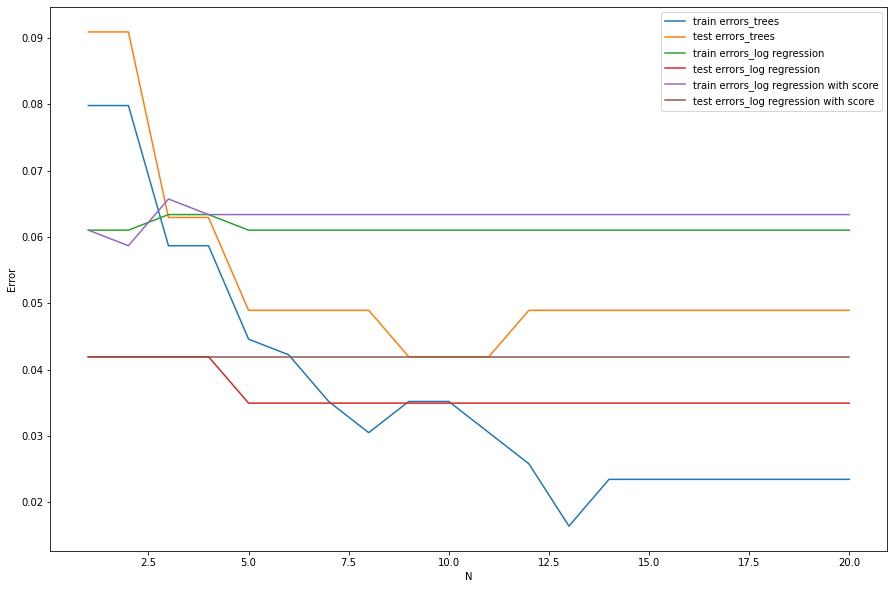

In [47]:
x = list(range(1, 21))

plt.figure(figsize=(15, 10))
plt.plot(x, train_errors_trees, label='train errors_trees')
plt.plot(x, test_errors_trees, label='test errors_trees')
plt.plot(x, train_errors_log_regression, label='train errors_log regression')
plt.plot(x, test_errors_log_regression, label='test errors_log regression')
plt.plot(x, train_errors_log_regression_with_score, label='train errors_log regression with score')
plt.plot(x, test_errors_log_regression_with_score, label='test errors_log regression with score')
plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right')

In [48]:
log_regression_answers_test = predict(X_test, models)
a = np.equal(y_test, log_regression_answers_test)
a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [49]:
log_regression_answers_test_with_score = predict_log_regression(X_test, models)
b = np.equal(y_test, log_regression_answers_test_with_score)
b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [50]:
c = np.logical_xor(a, b)
c

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [51]:
np.where(c)[0]

array([130])